# **Setup and Import**

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
!cp -r /content/drive/MyDrive/CS441/FinalProject/dataset .

In [136]:
!pip install librosa soundfile transformers torchaudio seaborn

In [137]:
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Wav2Vec2Model

In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [143]:
def collect_files(root_dir):
    """
    Collect (path, label_idx) pairs in a stable order:
    - classes sorted
    - filenames sorted
    This guarantees mel_dataset and wav_dataset have identical ordering.
    """
    classes = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
    ])
    class_to_idx = {c: i for i, c in enumerate(classes)}

    samples = []
    labels = []
    for c in classes:
        folder = os.path.join(root_dir, c)
        for f in sorted(os.listdir(folder)):
            if f.endswith(".wav") and not f.startswith("."):
                samples.append(os.path.join(folder, f))
                labels.append(class_to_idx[c])

    return samples, np.array(labels), classes


ROOT = "dataset"
all_paths, all_labels, classes = collect_files(ROOT)
idx_to_class = {i: c for i, c in enumerate(classes)}
num_classes = len(classes)

print("Classes:", classes)
print("Total samples:", len(all_paths))

# Shared split indices for ALL models (fair comparison)
indices = np.arange(len(all_paths))
train_idx, test_idx = train_test_split(
    indices, test_size=0.15, stratify=all_labels, random_state=42
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.176, stratify=all_labels[train_idx], random_state=42
)

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))

Classes: ['angry', 'calm', 'happy', 'sad']
Total samples: 217
Train: 151 Val: 33 Test: 33


# **1. Dataset (Mel-Spectrogram + Path)**

In [144]:
class EmotionMelDataset(Dataset):
    def __init__(self, paths, labels, sr=16000, max_t=200):
        self.paths = paths
        self.labels = labels
        self.sr = sr
        self.max_t = max_t

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        y, _ = librosa.load(path, sr=self.sr, mono=True)

        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=128)
        mel = librosa.power_to_db(mel, ref=np.max)

        # Normalize to [0,1]
        mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-6)

        # Pad / truncate time axis
        if mel.shape[1] < self.max_t:
            mel = np.pad(mel, ((0,0),(0, self.max_t - mel.shape[1])))
        else:
            mel = mel[:, :self.max_t]

        x = torch.tensor(mel).unsqueeze(0).float()  # [1, 128, max_t]
        y = int(self.labels[idx])
        return x, y, path


mel_ds = EmotionMelDataset(all_paths, all_labels, sr=16000, max_t=200)

mel_train_loader = DataLoader(Subset(mel_ds, train_idx), batch_size=8, shuffle=True)
mel_val_loader   = DataLoader(Subset(mel_ds, val_idx),   batch_size=8, shuffle=False)
mel_test_loader  = DataLoader(Subset(mel_ds, test_idx),  batch_size=8, shuffle=False)

In [145]:
class EmotionWavDataset(Dataset):
    def __init__(self, paths, labels, sr=16000, max_sec=4):
        self.paths = paths
        self.labels = labels
        self.sr = sr
        self.max_len = max_sec * sr

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        wav, _ = librosa.load(path, sr=self.sr, mono=True)

        # Pad / truncate waveform
        if len(wav) < self.max_len:
            wav = np.pad(wav, (0, self.max_len - len(wav)))
        else:
            wav = wav[:self.max_len]

        x = torch.tensor(wav).float()  # [T]
        y = int(self.labels[idx])
        return x, y, path


wav_ds = EmotionWavDataset(all_paths, all_labels, sr=16000, max_sec=4)

wav_train_loader = DataLoader(Subset(wav_ds, train_idx), batch_size=4, shuffle=True)
wav_val_loader   = DataLoader(Subset(wav_ds, val_idx),   batch_size=4, shuffle=False)
wav_test_loader  = DataLoader(Subset(wav_ds, test_idx),  batch_size=4, shuffle=False)

# **2. Evaluation helpers**

In [146]:
def evaluate_acc_f1(model, loader, device):
    model.eval()
    preds, gts, paths = [], [], []
    with torch.no_grad():
        for x, y, p in loader:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            gts.extend(np.array(y))
            paths.extend(list(p))

    preds = np.array(preds)
    gts = np.array(gts)

    acc = (preds == gts).mean()
    macro_f1 = f1_score(gts, preds, average="macro")

    return acc, macro_f1, preds, gts, paths


def train_with_best_checkpoint(
    model, train_loader, val_loader, device,
    epochs=30, lr=1e-3, ckpt_path="best_model.pt", print_prefix=""
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_f1s = []
    best_f1 = -1
    best_epoch = -1

    for epoch in range(epochs):
        model.train()
        running = 0.0

        for x, y, _ in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            running += loss.item()

        train_loss = running / max(1, len(train_loader))
        train_losses.append(train_loss)

        val_acc, val_f1, _, _, _ = evaluate_acc_f1(model, val_loader, device)
        val_f1s.append(val_f1)

        print(f"{print_prefix}Epoch {epoch+1}: Train Loss={train_loss:.3f}, Val Macro-F1={val_f1:.3f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch + 1
            torch.save(model.state_dict(), ckpt_path)

    return train_losses, val_f1s, best_epoch, best_f1

# **3. Model**

**CNN**

In [147]:
class CNNEmotion(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.net(x)
        return self.fc(x.view(x.size(0), -1))


cnn_model = CNNEmotion(num_classes).to(device)

cnn_train_losses, cnn_val_f1s, cnn_best_epoch, cnn_best_f1 = train_with_best_checkpoint(
    cnn_model,
    mel_train_loader, mel_val_loader,
    device=device,
    epochs=30, lr=1e-3,
    ckpt_path="best_cnn.pt",
    print_prefix="[CNN] "
)

cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))
cnn_test_acc, cnn_test_f1, cnn_test_pred, y_true, test_paths = evaluate_acc_f1(cnn_model, mel_test_loader, device)

print("\n[CNN] Best Epoch:", cnn_best_epoch)
print("[CNN] Test Accuracy:", cnn_test_acc)
print("[CNN] Test Macro-F1:", cnn_test_f1)

[CNN] Epoch 1: Train Loss=1.382, Val Macro-F1=0.116
[CNN] Epoch 2: Train Loss=1.371, Val Macro-F1=0.116
[CNN] Epoch 3: Train Loss=1.358, Val Macro-F1=0.116
[CNN] Epoch 4: Train Loss=1.350, Val Macro-F1=0.107
[CNN] Epoch 5: Train Loss=1.329, Val Macro-F1=0.404
[CNN] Epoch 6: Train Loss=1.304, Val Macro-F1=0.226
[CNN] Epoch 7: Train Loss=1.279, Val Macro-F1=0.274
[CNN] Epoch 8: Train Loss=1.249, Val Macro-F1=0.383
[CNN] Epoch 9: Train Loss=1.209, Val Macro-F1=0.174
[CNN] Epoch 10: Train Loss=1.257, Val Macro-F1=0.274
[CNN] Epoch 11: Train Loss=1.214, Val Macro-F1=0.292
[CNN] Epoch 12: Train Loss=1.159, Val Macro-F1=0.476
[CNN] Epoch 13: Train Loss=1.120, Val Macro-F1=0.486
[CNN] Epoch 14: Train Loss=1.088, Val Macro-F1=0.447
[CNN] Epoch 15: Train Loss=1.095, Val Macro-F1=0.448
[CNN] Epoch 16: Train Loss=1.074, Val Macro-F1=0.512
[CNN] Epoch 17: Train Loss=1.043, Val Macro-F1=0.447
[CNN] Epoch 18: Train Loss=1.038, Val Macro-F1=0.422
[CNN] Epoch 19: Train Loss=1.062, Val Macro-F1=0.424
[C

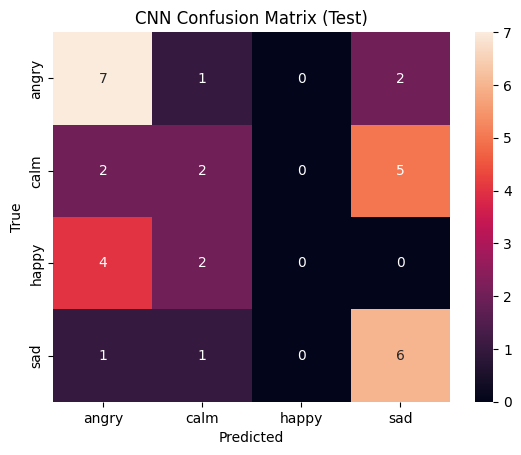

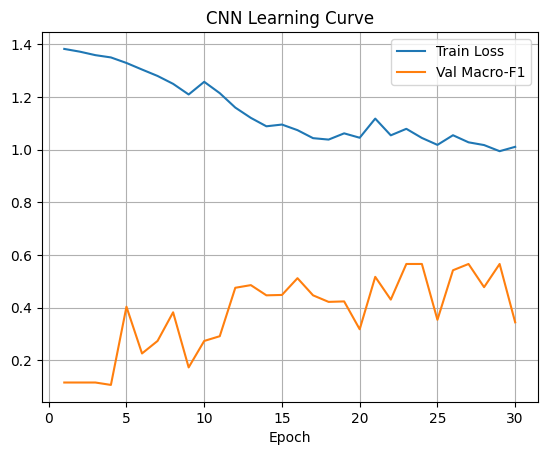

In [148]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_learning(train_losses, val_f1s, title):
    epochs = range(1, len(train_losses)+1)
    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_f1s, label="Val Macro-F1")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_confusion(y_true, cnn_test_pred, "CNN Confusion Matrix (Test)")
plot_learning(cnn_train_losses, cnn_val_f1s, "CNN Learning Curve")

**CRNN**

[CRNN] Epoch 1: Train Loss=1.405, Val Macro-F1=0.116
[CRNN] Epoch 2: Train Loss=1.355, Val Macro-F1=0.172
[CRNN] Epoch 3: Train Loss=1.305, Val Macro-F1=0.368
[CRNN] Epoch 4: Train Loss=1.218, Val Macro-F1=0.522
[CRNN] Epoch 5: Train Loss=1.033, Val Macro-F1=0.551
[CRNN] Epoch 6: Train Loss=1.014, Val Macro-F1=0.377
[CRNN] Epoch 7: Train Loss=0.889, Val Macro-F1=0.643
[CRNN] Epoch 8: Train Loss=0.794, Val Macro-F1=0.641
[CRNN] Epoch 9: Train Loss=0.714, Val Macro-F1=0.620
[CRNN] Epoch 10: Train Loss=0.760, Val Macro-F1=0.620
[CRNN] Epoch 11: Train Loss=0.740, Val Macro-F1=0.552
[CRNN] Epoch 12: Train Loss=0.625, Val Macro-F1=0.573
[CRNN] Epoch 13: Train Loss=0.643, Val Macro-F1=0.565
[CRNN] Epoch 14: Train Loss=0.570, Val Macro-F1=0.648
[CRNN] Epoch 15: Train Loss=0.562, Val Macro-F1=0.598
[CRNN] Epoch 16: Train Loss=0.529, Val Macro-F1=0.558
[CRNN] Epoch 17: Train Loss=0.522, Val Macro-F1=0.565
[CRNN] Epoch 18: Train Loss=0.476, Val Macro-F1=0.509
[CRNN] Epoch 19: Train Loss=0.444, Va

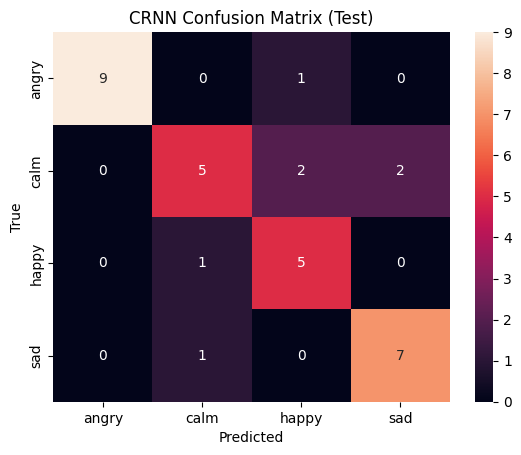

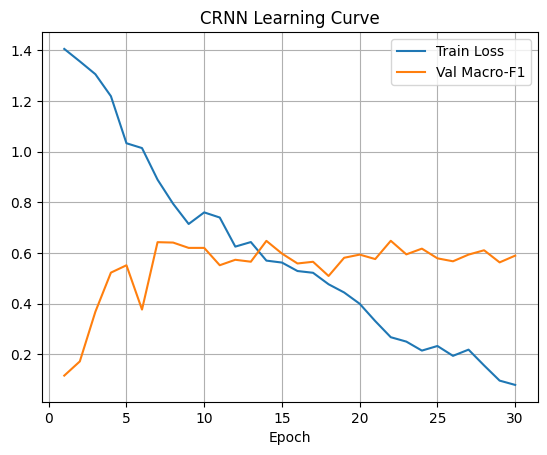

In [149]:
class CRNNEmotion(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gru = nn.GRU(
            input_size=32 * 32,   # 1024
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(64 * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)                 # [B, 32, 32, 50] when input is [B,1,128,200]
        x = x.permute(0, 3, 1, 2)       # [B, 50, 32, 32]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [B, 50, 1024]
        out, _ = self.gru(x)            # [B, 50, 128]
        out = out.mean(dim=1)
        return self.fc(out)


crnn_model = CRNNEmotion(num_classes).to(device)

crnn_train_losses, crnn_val_f1s, crnn_best_epoch, crnn_best_f1 = train_with_best_checkpoint(
    crnn_model,
    mel_train_loader, mel_val_loader,
    device=device,
    epochs=30, lr=1e-3,
    ckpt_path="best_crnn.pt",
    print_prefix="[CRNN] "
)

crnn_model.load_state_dict(torch.load("best_crnn.pt", map_location=device))
crnn_test_acc, crnn_test_f1, crnn_test_pred, _, _ = evaluate_acc_f1(crnn_model, mel_test_loader, device)

print("\n[CRNN] Best Epoch:", crnn_best_epoch)
print("[CRNN] Test Accuracy:", crnn_test_acc)
print("[CRNN] Test Macro-F1:", crnn_test_f1)

plot_confusion(y_true, crnn_test_pred, "CRNN Confusion Matrix (Test)")
plot_learning(crnn_train_losses, crnn_val_f1s, "CRNN Learning Curve")

**wav2vec2 Model**

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


[W2V] Epoch 1: Train Loss=1.273, Val Macro-F1=0.510
[W2V] Epoch 2: Train Loss=0.861, Val Macro-F1=0.555
[W2V] Epoch 3: Train Loss=0.612, Val Macro-F1=0.658
[W2V] Epoch 4: Train Loss=0.429, Val Macro-F1=0.709
[W2V] Epoch 5: Train Loss=0.442, Val Macro-F1=0.611
[W2V] Epoch 6: Train Loss=0.320, Val Macro-F1=0.681
[W2V] Epoch 7: Train Loss=0.265, Val Macro-F1=0.769
[W2V] Epoch 8: Train Loss=0.270, Val Macro-F1=0.573
[W2V] Epoch 9: Train Loss=0.114, Val Macro-F1=0.709
[W2V] Epoch 10: Train Loss=0.135, Val Macro-F1=0.798
[W2V] Epoch 11: Train Loss=0.071, Val Macro-F1=0.714
[W2V] Epoch 12: Train Loss=0.025, Val Macro-F1=0.798
[W2V] Epoch 13: Train Loss=0.008, Val Macro-F1=0.718
[W2V] Epoch 14: Train Loss=0.004, Val Macro-F1=0.798
[W2V] Epoch 15: Train Loss=0.002, Val Macro-F1=0.798
[W2V] Epoch 16: Train Loss=0.001, Val Macro-F1=0.798
[W2V] Epoch 17: Train Loss=0.001, Val Macro-F1=0.798
[W2V] Epoch 18: Train Loss=0.001, Val Macro-F1=0.798
[W2V] Epoch 19: Train Loss=0.001, Val Macro-F1=0.798
[W

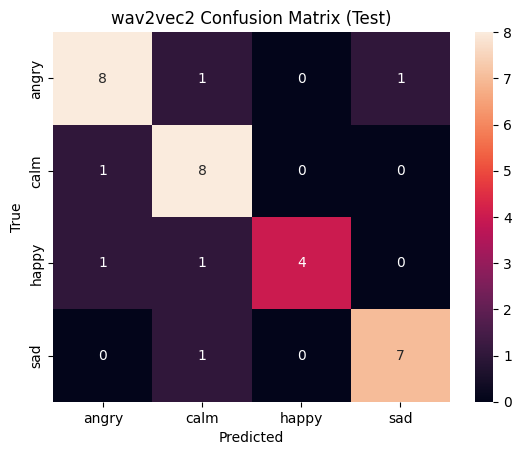

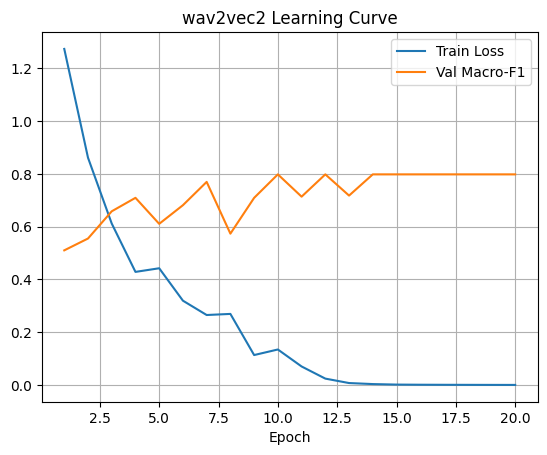

In [150]:
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
wav2vec.eval()
for p in wav2vec.parameters():
    p.requires_grad = False
wav2vec = wav2vec.to(device)

class Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.gru = nn.GRU(
            input_size=768,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: [B, T] waveform
        with torch.no_grad():
            feats = wav2vec(x).last_hidden_state  # [B, T', 768]
        out, _ = self.gru(feats)
        out = out.mean(dim=1)
        return self.fc(out)


w2v_model = Wav2Vec2Classifier(num_classes).to(device)

w2v_train_losses, w2v_val_f1s, w2v_best_epoch, w2v_best_f1 = train_with_best_checkpoint(
    w2v_model,
    wav_train_loader, wav_val_loader,   # IMPORTANT: waveform loaders
    device=device,
    epochs=20, lr=1e-3,
    ckpt_path="best_wav2vec2.pt",
    print_prefix="[W2V] "
)

w2v_model.load_state_dict(torch.load("best_wav2vec2.pt", map_location=device))
w2v_test_acc, w2v_test_f1, w2v_test_pred, _, wav_test_paths = evaluate_acc_f1(w2v_model, wav_test_loader, device)

# Sanity check: same test paths order as mel_test_loader
assert list(test_paths) == list(wav_test_paths), "Test path order mismatch between mel and wav pipelines!"

print("\n[W2V] Best Epoch:", w2v_best_epoch)
print("[W2V] Test Accuracy:", w2v_test_acc)
print("[W2V] Test Macro-F1:", w2v_test_f1)

plot_confusion(y_true, w2v_test_pred, "wav2vec2 Confusion Matrix (Test)")
plot_learning(w2v_train_losses, w2v_val_f1s, "wav2vec2 Learning Curve")

# ** 4. Unified comparison + error analysis (cross-model)

In [151]:
results = pd.DataFrame({
    "path": test_paths,
    "true": y_true,
    "true_label": [idx_to_class[i] for i in y_true],

    "cnn_pred": cnn_test_pred,
    "cnn_label": [idx_to_class[i] for i in cnn_test_pred],

    "crnn_pred": crnn_test_pred,
    "crnn_label": [idx_to_class[i] for i in crnn_test_pred],

    "w2v_pred": w2v_test_pred,
    "w2v_label": [idx_to_class[i] for i in w2v_test_pred],
})

results["cnn_wrong"]  = results["cnn_pred"]  != results["true"]
results["crnn_wrong"] = results["crnn_pred"] != results["true"]
results["w2v_wrong"]  = results["w2v_pred"]  != results["true"]
results["wrong_count"] = results[["cnn_wrong","crnn_wrong","w2v_wrong"]].sum(axis=1)

# Summary table
summary = pd.DataFrame({
    "Test Accuracy": [cnn_test_acc, crnn_test_acc, w2v_test_acc],
    "Test Macro-F1": [cnn_test_f1,  crnn_test_f1,  w2v_test_f1],
}, index=["CNN", "CRNN", "wav2vec2"])

print("\n=== Model Comparison Summary ===")
display(summary)

# Hard samples: misclassified by >= 2 models
hard_samples = results[results["wrong_count"] >= 2].copy()
hard_samples = hard_samples.sort_values("wrong_count", ascending=False)

print("\n=== Hard Samples (wrong by >=2 models) ===")
display(hard_samples[[
    "path","true_label","cnn_label","crnn_label","w2v_label","wrong_count"
]].head(20))


=== Model Comparison Summary ===


,Test Accuracy,Test Macro-F1
CNN,0.454545,0.355357
CRNN,0.787879,0.777546
wav2vec2,0.818182,0.818750



=== Hard Samples (wrong by >=2 models) ===


,path,true_label,cnn_label,crnn_label,w2v_label,wrong_count
0,dataset/happy/happy_09.wav,happy,angry,happy,angry,2
5,dataset/angry/angry_19.wav,angry,sad,angry,sad,2
11,dataset/happy/happy_28.wav,happy,calm,calm,happy,2
17,dataset/calm/calm_47.wav,calm,sad,sad,calm,2
22,dataset/calm/calm_02.wav,calm,sad,sad,calm,2
24,dataset/calm/calm_36.wav,calm,sad,happy,calm,2
27,dataset/happy/happy_34.wav,happy,calm,happy,calm,2
